# riverbed parameters

Thanks to this script we will carry out an inversion of the parameters of the riverbed, t
The inversion will focus on the four uncertain parameters and one boundary condition of this model, namely:

- the porosity $n$
- the intinsic permeability k,
- the thermal condictivity, 
- the heat capacity, 



# 1. Initiation Ginnette files

In [104]:
#!/usr/bin/env python

import os
import numpy as np
from pathlib import Path
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import subprocess
import glob
import itertools
import seaborn as sns
import array
from scipy.interpolate import CubicSpline

libs_gfortran = ['gfortran']
# Définissez le répertoire où se trouvent les fichiers CSV
Obs_data = '../OBS_point/signy-amont/'

#-----------------------------------------------------------------
########### Setup of the model

#time step in s
dt=900
#duration of the simulation in days
nb_day=30
date_simul_bg=pd.to_datetime("2022-04-01 14:00:00")
# state
## 0 steady state
# 1 transient state (dynamic state)
state=1
coef=-1
ost=0
# size columnin meter
z_top=0.0
z_bottom=-0.4
#Observation positions x 0.50000
#Observation in meter
Obs1=z_top-0.1
Obs2=z_top-0.2
Obs3=z_top-0.3
Obs4=z_top-0.4

az=abs(z_top-z_bottom)
#discretisation : size cell in meter
dz=0.01

# number of facies in the column. If nb_zone=1 homognous porous media
nb_zone=1
#cote de la limitein meter, if you want more layer just add a new line
alt_thk=-0.25

# number of cell
nb_cell=az/dz




# please compile ginette in the folder 1D_col
# path of the 1D_col directory
os.chdir('/home/ariviere/Programmes/ginette/application/sauer/GINETTE_SENSI/')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

#-----------------------------------------------------------------
# Compile ginette
if os.path.isfile('ginette'):
    print ("ginette exist")
else:
    print ("ginette not exist")
    print("you must compile ginette in the current directory")
    print(" gfortran -o ginette ../../src/ginette_V2.f")
    subprocess.call(["gfortran","-o","ginette","../../../src/ginette_V2.f"])  #creat


print("la simulation commence à",date_simul_bg)
#-----------------------------------------------------------------
## write the setup of the moddeled domain
f_param_bck=open("E_parametre_backup.dat", "r")
f_param_new = open("E_parametre.dat", 'w')
setup_model=f_param_bck.read()
setup_model=setup_model.replace('[dt]','%06.0fD+00' % dt)
setup_model=setup_model.replace('[state]','%1i' % state)
setup_model=setup_model.replace('[nb_day]','%06.0f' % nb_day)
setup_model=setup_model.replace('[z_top]', '%7.3e' % z_top)
setup_model=setup_model.replace('[z_bottom]', '%7.2e' % z_bottom)
setup_model=setup_model.replace('[az]','%7.3e' % az)
setup_model=setup_model.replace('[dz]','%6.2e' % dz)
setup_model=setup_model.replace('[nb_cell]','%05.0f' % nb_cell)

cell1=abs(Obs1/dz)
cell2=abs(Obs2/dz)
cell3=abs(Obs3/dz)
cell4=abs(Obs4/dz)

setup_model=setup_model.replace('[cell1]','%05d' % cell1)
setup_model=setup_model.replace('[cell2]','%05d' % cell2)
setup_model=setup_model.replace('[cell3]','%05d' % cell3)
setup_model=setup_model.replace('[cell4]','%05d' % cell4)



f_param_new.write(setup_model)
f_param_bck.close()
f_param_new.close()






Current working directory: /home/ariviere/Programmes/ginette/application/sauer/GINETTE_SENSI
ginette exist
la simulation commence à 2022-04-01 14:00:00


# 2. Read observation data

In [105]:

# Obtenez la liste des fichiers dans le répertoire
fichiers = os.listdir(Obs_data)

info = None
all_data = None

for fichier in fichiers:
    if fichier.endswith('.csv'):
        if 'info' in fichier:
            info = pd.read_csv(os.path.join(Obs_data, fichier))
        elif 'dP' in fichier:
            all_data = pd.read_csv(os.path.join(Obs_data, fichier))
all_data['dates']=pd.to_datetime(all_data['dates'],format='%Y-%m-%d %H:%M:%S')
all_data=all_data[all_data['dates']>date_simul_bg]
# Réindexer le DataFrame
all_data.reset_index(drop=True, inplace=True)
all_data['deltaP']=all_data['deltaP']*coef+ost


date_begin= all_data['dates'].iloc[0]
date_end = pd.to_datetime(date_begin) + pd.to_timedelta(nb_day, unit='d')
print(date_begin,date_end)
# pas de temps
time_diff = all_data['dates'].diff().dropna()
indices_not_equal_900_sec = time_diff[time_diff != pd.Timedelta(seconds=900)].index

# pas de temps=900s
is_equal_900_sec = all(time_diff == pd.Timedelta(seconds=900))

if len(indices_not_equal_900_sec) == 0:
    print("Toutes les différences entre les lignes sont de 900 secondes.")
else:
    print("Les différences ne sont pas toutes de 900 secondes. Voici les indices concernés :")
    print(indices_not_equal_900_sec)
    # Afficher les lignes correspondantes dans le dataframe
    print(all_data.loc[indices_not_equal_900_sec])
all_data['dates']

2022-04-14 13:45:00 2022-05-14 13:45:00
Les différences ne sont pas toutes de 900 secondes. Voici les indices concernés :
Index([9303, 14843, 22614], dtype='int64')
                    dates    VMolo    deltaP  TempMolo   Temp1   Temp2  \
9303  2022-07-20 14:06:21  1.27306  0.025912    23.901  23.970  23.546   
14843 2022-09-16 11:20:03  1.20228 -0.028065    16.726  16.769  16.790   
22614 2022-12-06 13:00:00  2.49996  1.281547     5.622   5.647   6.199   

        Temp3   Temp4  
9303   22.905  22.702  
14843  16.732  16.755  
22614   6.908   7.503  


0       2022-04-14 13:45:00
1       2022-04-14 14:00:00
2       2022-04-14 14:15:00
3       2022-04-14 14:30:00
4       2022-04-14 14:45:00
                ...        
40845   2023-06-14 10:45:00
40846   2023-06-14 11:00:00
40847   2023-06-14 11:15:00
40848   2023-06-14 11:30:00
40849   2023-06-14 11:45:00
Name: dates, Length: 40850, dtype: datetime64[ns]

In [106]:
# Trouver les horodatages qui ne commencent pas à des intervalles de 15 minutes et ajuster uniquement ceux-là
#mask = all_data['dates'].dt.minute % 15 != 0
#all_data.loc[mask, 'timestamps'] = all_data.loc[mask, 'dates'] - pd.to_timedelta(all_data.loc[mask, 'dates'].dt.minute % 15, unit='m')
# Réinitialiser les secondes à zéro pour tous les horodatages
all_data['dates'] = all_data['dates'].dt.floor('min')
all_data['dates'] = all_data['dates'].dt.floor('15T')


In [107]:

all_data['timestamps']=all_data['dates']

# Créez un nouvel index avec des dates toutes les 15 minutes
new_index = pd.date_range(start=all_data['timestamps'].min(), end=all_data['timestamps'].max(), freq='15T')

# Réindexez le DataFrame pour inclure ces nouvelles dates
all_data = all_data.set_index('timestamps').reindex(new_index)
# Sélection des colonnes pour l'interpolation
columns_to_interpolate = ['deltaP', 'TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']

# Appliquez l'interpolation uniquement sur la colonne 'valeur'
all_data[columns_to_interpolate] = all_data[columns_to_interpolate].interpolate(method='time')




In [108]:

# Vérification des écarts temporels après l'interpolation
time_diff = all_data['dates'].diff().dropna()
indices_not_equal_900_sec = time_diff[time_diff != pd.Timedelta(seconds=900)].index

if len(indices_not_equal_900_sec) == 0:
    print("Toutes les différences entre les lignes sont de 900 secondes.")
else:
    print("Les différences ne sont pas toutes de 900 secondes. Voici les indices concernés :")
    print(indices_not_equal_900_sec)
    # Afficher les lignes correspondantes dans le dataframe
    print(all_data.loc[indices_not_equal_900_sec])

Toutes les différences entre les lignes sont de 900 secondes.


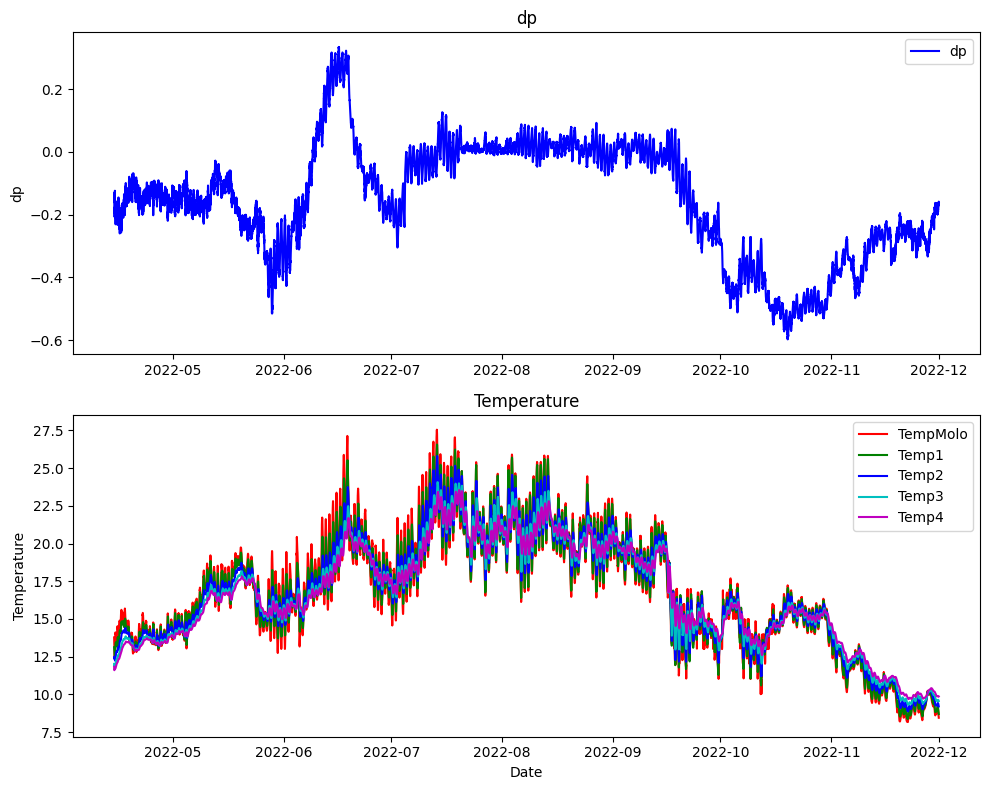

In [109]:
all_data= all_data[ (all_data['dates'] < '2022-12-01')]
# Creating subplots for 'dp' and 'temp' graphs vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting 'dp'
ax1.plot(all_data['dates'], all_data['deltaP'], 'b-', label='dp')
ax1.set_ylabel('dp')
ax1.set_title('dp')
ax1.legend()

# Plotting 'Temps'
temp_columns = ['TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']
colors = ['r', 'g', 'b', 'c', 'm']
for i, col in enumerate(temp_columns):
    ax2.plot(all_data['dates'], all_data[col], color=colors[i], label=col)

ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

# Zoom temperature



In [110]:
filtered_data = all_data[(all_data['dates'] > '2022-04-01') & (all_data['dates'] < '2022-05-16')]


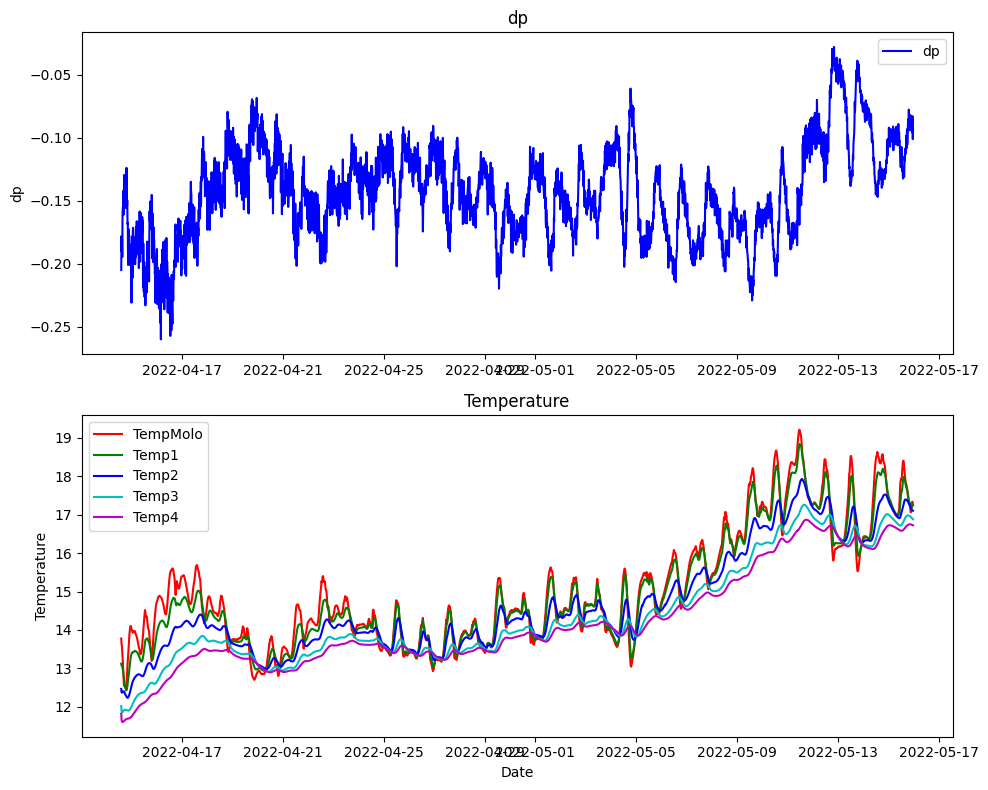

In [111]:
# Creating subplots for 'dp' and 'temp' graphs vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting 'dp'
ax1.plot(filtered_data['dates'],filtered_data['deltaP'], 'b-', label='dp')
ax1.set_ylabel('dp')
ax1.set_title('dp')
ax1.legend()

# Plotting 'Temps'
temp_columns = ['TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']
colors = ['r', 'g', 'b', 'c', 'm']
for i, col in enumerate(temp_columns):
    ax2.plot(filtered_data['dates'], filtered_data[col], color=colors[i], label=col)

ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

## 2. Boundary conditions 

In [112]:
########### Zone of parameters
f_coor=open("E_coordonnee.dat", "w")
f_zone=open("E_zone.dat", 'w')
f_paramZ_bck=open("E_zone_parameter_backup.dat", "r")
f_paramZ_new = open("E_zone_parameter.dat", 'w')

param_zone=f_paramZ_bck.read()
coord=pd.DataFrame()    

    
# Coodrinate  
zvalues =  np.sort(np.arange(z_bottom+dz/2,dz/2,dz ))

xvalues = np.array([0.5])
zz, xx = np.meshgrid(zvalues, xvalues)
NT = np.product(zz.shape)
data = {
    "x": np.reshape(xx,NT),
    "z": np.reshape(zz,NT)}
coord = pd.DataFrame(data=data)
coord['id']=coord.index.values.astype(int)
coord['id']=coord['id']+1
cols = coord.columns.tolist()
cols = cols[-1:] + cols[:-1]
coord = coord[cols] 
coord.to_csv(f_coor, index = False, sep=' ', header=False)
#zone parameter by cell ((homogenous domain = 1 zone))
coord['zone'] =1


#Pour plusieurs zones modification AR
if nb_zone >= 2:
        coord['zone'] = np.where(coord['z'] >= alt_thk, 2,coord['zone'])
#Write new ginette files
f_paramZ_new.write(param_zone)

coord.zone.to_csv(f_zone, index = False, header=False)

# close files    
f_zone.close()
f_coor.close()
f_paramZ_new.close()
f_paramZ_bck.close()






# Inital conditions
f_temp_IC=open("E_temperature_initiale.dat","w")
initial_temps = all_data.iloc[0][['Temp1', 'Temp2', 'Temp3', 'Temp4']]
z_temps = np.array([-0.1, -0.2, -0.3, -0.4])
initial = pd.DataFrame({'z': z_temps, 'T': initial_temps})
initial['z'] = initial['z'].astype(float)
initial['T'] = initial['T'].astype(float)


# Define the range of depths for interpolation
dz_bot=z_bottom+dz/2
dz_top=z_top+0.001
z_values = np.arange(dz_bot, 0.001, dz)  # Depth range from -0.4 to 0.005

# Perform linear interpolation
Temp_init = np.interp(z_values, initial['z'][::-1], initial['T'][::-1])  # Reversed to align with depths

# Creating a DataFrame for the interpolated data
interpolated_temp = {
    'z': z_values,
    'T': Temp_init
}

interpolated_temp = pd.DataFrame(interpolated_temp)
interpolated_temp_sorted = interpolated_temp.sort_values(by='z', ascending=False)

interpolated_temp_sorted['T'].to_csv(f_temp_IC, index = False, sep='\n', header=False)

# To apply dp to the column, we need to convert it to a pressure value
f_chg_IC=open("E_charge_initiale.dat","w")
initial_pres = all_data.iloc[0][['deltaP']]*-1
initial_chg = pd.DataFrame({'z': z_bottom, 'chg': [0]})
new_row = pd.DataFrame({'z': z_top, 'chg':initial_pres})
initial_chg = pd.concat([initial_chg, new_row], ignore_index=True)
initial_chg['z'] = initial_chg['z'].astype(float)
initial_chg['chg'] = initial_chg['chg'].astype(float)
# Define the range of depths for interpolation
dz_bot=z_bottom+dz/2
dz_top=z_top+0.001
z_values = np.arange(dz_bot, 0.001, dz)  # Depth range from -0.4 to 0.005


# Perform linear interpolation
charge_init = np.interp(z_values, initial_chg['z'][:], initial_chg['chg'][:])  # Reversed to align with depths

# Creating a DataFrame for the interpolated data
interpolated_chg = {
    'z': z_values,
    'chg': charge_init
}
interpolated_chg = pd.DataFrame(interpolated_chg)
interpolated_chg_sorted = interpolated_chg.sort_values(by='z', ascending=False)



interpolated_chg_sorted['chg'].to_csv(f_chg_IC, index = False, sep='\n', header=False)

f_chg_IC.close()
f_temp_IC.close()

In [113]:
# Boundary conditions
all_data['bot']=0
all_data['top']=all_data['deltaP']*-1
all_data[['top','bot']].to_csv('E_charge_t.dat', sep=' ', index=False, header=False)
all_data[['Temp1', 'Temp4']].to_csv('E_temp_t.dat', sep=' ', index=False, header=False)

## 2. Screening parmeters
### 2.1 Range definition


In [133]:
 # porosity
REF_n=0.38 # \omega
#-----------------------------------------------------------------
# constant parameters
## intrinsic permeability [m2]  k=K*mu/(rho*g)
## K hydraulic conductivity [m.s-1]
## mu viscosity [Pa.s]
## rho density [kg.m-3]
## g gravity  9.81 [m2.s-1]

# K=10**REF_k
REF_k=-12
# solid grain density rho_s=val_r  [kg.m-3]
REF_r=1600


# Heat capacity is calculated  by the following relationship
#  c_pm= c_w r_w n  * sat+ c_s r (1-n) + c_a r_a n * (1-sat)
# 1.5 e+6 4e+6
#rho_m imposed : 1000
# high slow
# density
# c_s solid specific heat capacity
#val_c= c_s m2/s2/C I advice to let this value constant.
# There are no way to calibrate the both parameter rho and c in the same time.
#c_w=4185D+00	       m2/s2/C
#r_w=1000  kg/m3
# solid density r=val_r 
REF_c=2650
REF_l=8 #



if nb_zone==2:
    # zone 2
    # porosity
    REF_n2=0.05 # \omega
    # intrinsic permeability [m2]  k=K*mu/(rho*g)
    REF_k2=-15
    # solid grain density rho_s=val_r  [kg.m-3]
    REF_r2=1600
    REF_l2=3
    

    
# Write the parameters to calibrate    
param_all = ["k", 'l', 'n','r']
param = ["l", "k"]

# deviation
dvt_k = 1 
dvt_n = 0
dvt_l=0
dvt_c=0

# number of values by parameters

i_k = 2
i_l=1
i_c=1
i_n=1
if nb_zone==2:
    i_l2=4
    i_k2=4
    i_c2=1
    i_n2=1


In [134]:
# k in param
if 'k' in param:
    range_k = [REF_k-dvt_k,REF_k+dvt_k]
if 'k2' in param:
    range_k2 = [REF_k2-dvt_k,REF_k2+dvt_k]
# n in param
if 'n' in param:
    range_n =  [REF_n-dvt_n,REF_n+dvt_n]
if 'n2' in param:
    range_n2 =  [REF_n2-dvt_n,REF_n2+dvt_n]
if 'l' in param:
    range_l =  [REF_l-dvt_l,REF_l+dvt_l]
if 'l2' in param:
    range_l2 =  [REF_l2-dvt_l,REF_l2+dvt_l]
if 'c' in param:
    range_c =  [REF_c-dvt_c,REF_c+dvt_c]
if 'c2' in param:
    range_c2 =  [REF_c2-dvt_c,REF_c2+dvt_c]           




if (range_l[0] < 0.8):
    range_l[0] = 0.8
if nb_zone==1:
    print("1 zone:",range_l,range_k)

if nb_zone==2:
    range_k2 = [REF_k2-dvt_k,REF_k2+dvt_k]
    range_l2 =  [REF_l2-dvt_l,REF_l2+dvt_l]
    if (range_l2[0] < 0.8):
        range_l2[0] = 0.8
    print("2 zones:",range_l,range_l2,range_k,range_k2)

1 zone: [8, 8] [-13, -11]


### 2.3 loop table param  à AMELIORER


In [135]:

import pandas as pd
import numpy as np
import itertools


parameter_table = pd.DataFrame()

for i in param:
    for x in param_all:
        if x != i:
            if 'k' in x:
                # Specify the desired 'k' values
                k_values = np.linspace(range_k[0], range_k[1], i_k)
                k_values = np.power(10, k_values)
                # Format values in scientific notation for 'k' columns
                value_k = k_values
            if 'k2' in x:
                k_values = np.linspace(range_k2[0], range_k2[1], i_k)
                k_values = np.power(10, k_values)
                value_k2 = k_values
            if 'l' in x:
                l_values = np.linspace(range_l[0], range_l[1], i_l)
                value_l = l_values
            if 'l2' in x:    
                l_values = np.linspace(range_l2[0], range_l2[1], i_l2)
                value_l2 = l_values
 # number parameter in param
nb_param = len(param)
#
 # Specify values exist parameter combinaitions
if nb_zone==1 :
    if 'k' in param and nb_param==1:
        parameter_combinations = list(itertools.product(value_k))
        parameter_table = pd.DataFrame(parameter_combinations, columns=['k'])
 # Specify values exist parameter combinaitions
    if 'k' in param and nb_param==2 and 'l' in param:
        parameter_combinations = list(itertools.product(value_k,value_l))
# Convert the list to a pandas DataFrame
        parameter_table = pd.DataFrame(parameter_combinations, columns=['k','l'])


# Display the parameter table
print(parameter_table)





              k    l
0  1.000000e-13  8.0
1  1.000000e-11  8.0


### 2.5 Misfit function

In [136]:
def rmse(predictions, ref,sigma):
    differences = ((predictions - ref)/sigma)                      #the DIFFERENCEs.
    differences_squared = differences ** 2                    #the SQUAREs of ^
    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^
    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val

In [138]:
import numpy as np

def calculate_metrics(data):
    metrics = {}

    for i in range(1, 4):
        sensor = f'Temp{i}'
        diff = data[f'{sensor}_sim'] - data[f'{sensor}_obs']
        
        rmse = np.sqrt(np.mean(diff**2))  # RMSE
        mae = np.mean(np.abs(diff))  # MAE
        bias = 100 * np.sum(diff) / np.sum(np.abs(data[f'{sensor}_obs']))  # PBias

        std_obs = data[f'{sensor}_obs'].std()
        std_sim = data[f'{sensor}_sim'].std()
        mean_obs = data[f'{sensor}_obs'].mean()
        mean_sim = data[f'{sensor}_sim'].mean()

        kge = 1 - np.sqrt((np.square(std_sim/std_obs - 1)) +
                            (np.square(mean_sim/mean_obs - 1)) +
                            (np.square(rmse/std_obs - 1)))

        metrics[sensor] = {'RMSE': rmse, 'MAE': mae, 'PBias': bias, 'KGE': kge}

    return metrics



### 2.6 loops of simulations



In [146]:
criteria = pd.DataFrame(columns=['k','l','n','r', 'RMSE1', 'MAE1', 'PBias1', 'KGE1','RMSE2', 'MAE2', 'PBias2', 'KGE2','RMSE3', 'MAE3', 'PBias3', 'KGE3'])
obs_temp = all_data[all_data['dates'] < date_end]
for i in parameter_table.index:
    print(i)
    criteria_i = pd.DataFrame(columns=['k','l','n','c', 'RMSE1', 'MAE1', 'PBias1', 'KGE1','RMSE2', 'MAE2', 'PBias2', 'KGE2','RMSE3', 'MAE3', 'PBias3', 'KGE3'])
    REF_k = parameter_table.loc[i, 'k']
    REF_l = parameter_table.loc[i, 'l']

    print(REF_k, REF_l)
    criteria_i['k'] = [REF_k]
    criteria_i['l'] = [REF_l]
    # write the setup of the parameter zone file
    # read E_zone_parameter.dat
    f_paramZ_new = open("E_zone_parameter.dat", 'w')
    # read E_zone_parameter_backup.dat
    f_paramZ_bck = open("E_zone_parameter_backup.dat", "r")
    # replace the parameter values
    param_zone = param_zone.replace('[k1]', '%8.2e' % REF_k)
    param_zone = param_zone.replace('[n1]', '%6.2f' % REF_n)
    param_zone = param_zone.replace('[l1]', '%6.2f' % REF_l)
    param_zone = param_zone.replace('[r1]', '%6.2f' % REF_r)
    # FILEPATH: /home/ariviere/Programmes/ginette/application/mini-LOMOS/grid_search_ginette_2PTT.ipynb
    if nb_zone == 2:
        f_param_bck.close()
        f_paramZ_bck = open("E_zone_parameter_backup_2zones.dat", "r")
        param_zone = f_paramZ_bck.read()
        param_zone = param_zone.replace('[k1]', '%8.2e' % REF_k)
        param_zone = param_zone.replace('[n1]', '%6.2f' % REF_n)
        param_zone = param_zone.replace('[l1]', '%6.2f' % REF_l)
        param_zone = param_zone.replace('[r1]', '%6.2f' % REF_r)
        param_zone = param_zone.replace('[k2]', '%8.2e' % REF_k2)
        param_zone = param_zone.replace('[n2]', '%6.2f' % REF_n2)
        param_zone = param_zone.replace('[l2]', '%6.2f' % REF_l2)
        param_zone = param_zone.replace('[r2]', '%6.2f' % REF_r2)

    f_paramZ_new.write(param_zone)
    f_paramZ_new.close()
    f_paramZ_bck.close()

    # run ginette
    subprocess.call(["./ginette"])

    # save the results
    # Colonnes pour les températures
    column_names = ['Temp_1', 'Temp_2', 'Temp_3']

    # Liste pour stocker les DataFrames
    all_dfs = []
    # Lire et stocker les DataFrames
    for i in range(1, 4):
        file_path = f'Sim_temperature_maille{i}_t.dat'
        df = pd.read_csv(file_path, sep='\s+', header=None, names=['Time', f'Temp{i}'])
        all_dfs.append(df)

    # Fusionner les DataFrames sur la colonne 'Time'
    sim_temp = all_dfs[0]  # Utiliser le premier DataFrame comme base

    for df in all_dfs[1:]:
        sim_temp = pd.merge(sim_temp, df, on='Time', how='outer')

    # Trier les colonnes par ordre numérique
    sim_temp = sim_temp.reindex(sorted(sim_temp.columns), axis=1)
    sim_temp['dates'] = pd.to_datetime(date_simul_bg) + pd.to_timedelta(sim_temp['Time'], unit='s')

    # save files with parameters in the name files
    filename = "OUTPUT/Ref_k_{}_Ref_l_{}_Ref_n_{}_Ref_n_{}.csv".format(REF_k, REF_l, REF_n, REF_r)
    sim_temp.to_csv(filename, index=False)
    # Fusionner les DataFrames en fonction des dates communes
    obs_sim = pd.merge(obs_temp, sim_temp, on='dates', how='inner')
  
    obs_sim = obs_sim.rename(columns={
    'Temp1_x': 'Temp1_obs',
    'Temp2_x': 'Temp2_obs',
    'Temp3_x': 'Temp3_obs',
    'Temp1_y': 'Temp1_sim',
    'Temp2_y': 'Temp2_sim',
    'Temp3_y': 'Temp3_sim'})
    metrics_dict = calculate_metrics(obs_sim)
    # Affichage des résultats
    # Loop through each sensor and save the metrics to the dataframe
    for sensor, metrics in metrics_dict.items():
        if sensor == 'Temp1':
            criteria_i['RMSE1'] = metrics['RMSE']
            criteria_i['MAE1'] = metrics['MAE']
            criteria_i['PBias1'] = metrics['PBias']
            criteria_i['KGE1'] = metrics['KGE']
            
        elif sensor == 'Temp2':
            criteria_i['RMSE2'] = metrics['RMSE']
            criteria_i['MAE2'] = metrics['MAE']
            criteria_i['PBias2'] = metrics['PBias']
            criteria_i['KGE2'] = metrics['KGE']
        elif sensor == 'Temp3':
            criteria_i['RMSE3'] = metrics['RMSE']
            criteria_i['MAE3'] = metrics['MAE']
            criteria_i['PBias3'] = metrics['PBias']
            criteria_i['KGE3'] = metrics['KGE']
            
  # concatene the criteria_i to the criteria
    criteria=pd.concat([criteria,criteria_i],ignore_index=True)
        

# Save the dataframe to a CSV file
criteria.to_csv('SENSI/simulation_results.csv', index=False)

0
1e-13 8.0


/tmp/ipykernel_12848/3778854244.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  criteria=pd.concat([criteria,criteria_i],ignore_index=True)


1
1e-11 8.0


In [158]:
# trouver tous les fichiers csv débutant avec    Ref_k
import glob
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
criteria=pd.DataFrame(columns=['k','l','n','r', 'RMSE1', 'MAE1', 'PBias1', 'KGE1','RMSE2', 'MAE2', 'PBias2', 'KGE2','RMSE3', 'MAE3', 'PBias3', 'KGE3'])
# find file with Ref_k
path = os.getcwd()
path_output = os.path.join(path, 'OUTPUT')
files = os.listdir(path_output)
files_csv = [f for f in files if f[-3:] == 'csv']
files_csv = [f for f in files_csv if 'Ref_k' in f]

# read in past_output
df_test=pd.read_csv(os.path.join(path_output,files_csv[0]))
    
df_test['dates'] = pd.to_datetime(df_test['dates'])
print(df_test.head())
obs_sim = pd.merge(obs_temp, df_test, on='dates', how='inner')
obs_sim = obs_sim.rename(columns={
    'Temp1_x': 'Temp1_obs',
    'Temp2_x': 'Temp2_obs',
    'Temp3_x': 'Temp3_obs',
    'Temp1_y': 'Temp1_sim',
    'Temp2_y': 'Temp2_sim',
    'Temp3_y': 'Temp3_sim'})
metrics_dict = calculate_metrics(obs_sim)

       Temp1      Temp2      Temp3    Time               dates
0  13.001566  12.489194  11.909919   900.0 2022-04-01 14:15:00
1  12.891068  12.416993  11.805228  1800.0 2022-04-01 14:30:00
2  12.815568  12.330656  11.756790  2700.0 2022-04-01 14:45:00
3  12.739325  12.250978  11.737799  3600.0 2022-04-01 15:00:00
4  12.690824  12.189154  11.731626  4500.0 2022-04-01 15:15:00


In [160]:

# Create a list of dataframes with the value of Ref_k  Ref_k2 Ref_l Ref_l2 in the name
dfs = []

for file in files_csv:
    obs_sim = pd.DataFrame()
    df = pd.read_csv(os.path.join(path_output,file))
    # add the value of Ref_k  Ref_k2 Ref_l Ref_l2 in the dataframe
    df['Ref_k'] = file.split('_')[2]
    df['Ref_k2'] = file.split('_')[5]
    df['Ref_l'] = file.split('_')[8]
    df['Ref_l2'] = file.split('_')[11]
    # remove .csv fro df['Ref_l2]
    df['Ref_l2'] = df['Ref_l2'].str.replace('.csv', '')
    df['Ref_k'] = df['Ref_k'].astype(float)
    df['Ref_k2'] = df['Ref_k2'].astype(float)
    df['Ref_l'] = df['Ref_l'].astype(float)
    df['Ref_l2'] = df['Ref_l2'].astype(float)
    # calculate crietria
    df['dates']= pd.to_datetime(df['dates'])
    sim_temp = df
    
    criteria_i=pd.DataFrame(columns=['k','k2','l','l2', 'RMSE1', 'MAE1', 'PBias1', 'KGE1','RMSE2', 'MAE2', 'PBias2', 'KGE2','RMSE3', 'MAE3', 'PBias3', 'KGE3'])
    criteria_i['k'] = [df['Ref_k'][0]]
    criteria_i['k2'] = [df['Ref_k2'][0]]
    criteria_i['l'] = [df['Ref_l'][0]]
    criteria_i['l2'] = [df['Ref_l2'][0]]
    # Loop through each sensor and save the metrics to the dataframe
    obs_sim = pd.merge(obs_temp, sim_temp, on='dates', how='inner')
    obs_sim = obs_sim.rename(columns={
    'Temp1_x': 'Temp1_obs',
    'Temp2_x': 'Temp2_obs',
    'Temp3_x': 'Temp3_obs',
    'Temp1_y': 'Temp1_sim',
    'Temp2_y': 'Temp2_sim',
    'Temp3_y': 'Temp3_sim'})
  
    metrics_dict = calculate_metrics(obs_sim)
    for sensor, metrics in metrics_dict.items():
        if sensor == 'Temp1':
            criteria_i['RMSE1'] = metrics['RMSE']
            criteria_i['MAE1'] = metrics['MAE']
            criteria_i['PBias1'] = metrics['PBias']
            criteria_i['KGE1'] = metrics['KGE']
            
        elif sensor == 'Temp2':
            criteria_i['RMSE2'] = metrics['RMSE']
            criteria_i['MAE2'] = metrics['MAE']
            criteria_i['PBias2'] = metrics['PBias']
            criteria_i['KGE2'] = metrics['KGE']
        elif sensor == 'Temp3':
            criteria_i['RMSE3'] = metrics['RMSE']
            criteria_i['MAE3'] = metrics['MAE']
            criteria_i['PBias3'] = metrics['PBias']
            criteria_i['KGE3'] = metrics['KGE']


    # concatene the criteria_i to the criteria
    criteria=pd.concat([criteria,criteria_i],ignore_index=True) 


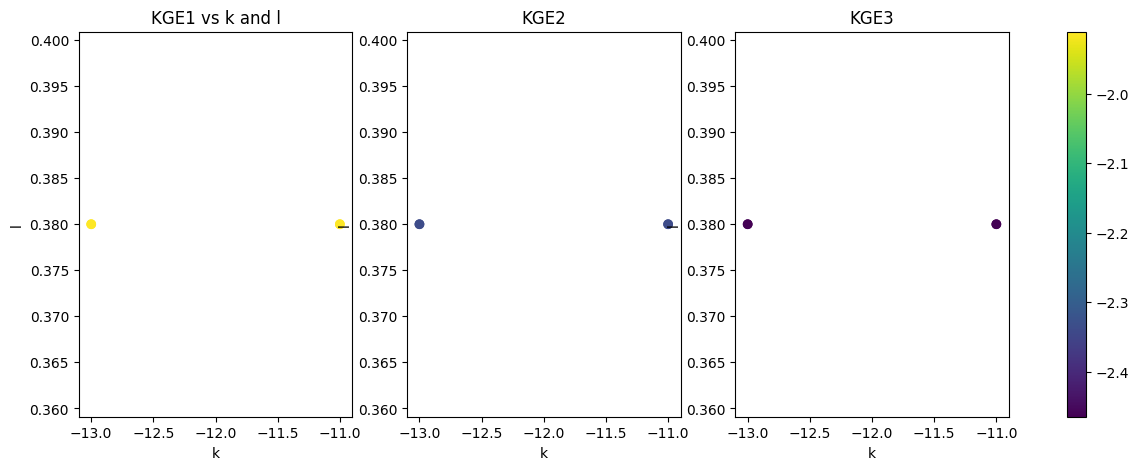

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the minimum and maximum values of RMSE1, RMSE2, and RMSE3
min_rmse = min(criteria[['KGE1', 'KGE2', 'KGE3']].min())
max_rmse = max(criteria[['KGE1', 'KGE2', 'KGE3']].max())

# Create a normalization instance
norm = Normalize(vmin=min_rmse, vmax=max_rmse)

# Tracer RMSE 1 plot log scale for k and l
scatter1 = axs[0].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['KGE1'], marker='o', cmap='viridis', norm=norm)
axs[0].set_xlabel('k')
axs[0].set_ylabel('l')
axs[0].set_title('KGE1 vs k and l')

# Tracer RMSE 2
scatter2 = axs[1].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['KGE2'], marker='o', cmap='viridis', norm=norm)
axs[1].set_xlabel('k')
axs[1].set_ylabel('l')
axs[1].set_title('KGE2')

# Tracer RMSE 3
scatter3 = axs[2].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['KGE3'], marker='o', cmap='viridis', norm=norm)
axs[2].set_xlabel('k')
axs[2].set_ylabel('l')
axs[2].set_title('KGE3')

# Create a single colorbar using the first scatter plot
colorbar = fig.colorbar(scatter1, ax=axs.ravel().tolist())

plt.show()
